In [17]:
import numpy as np
import pandas as pd
import gym
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import torch.nn.functional as F
import torch

In [18]:
gym.__version__

'0.23.1'

In [19]:
env= gym.make('CartPole-v1')

In [20]:
env.observation_space.shape[0]

4

In [21]:
class critic(nn.Module):
    def __init__(self,state_space,action_space):
        super(critic,self).__init__()
        self.fc1= nn.Linear(state_space,64)
        self.fc2= nn.Linear(64,64)
        self.fc3= nn.Linear(64,action_space)
    def forward(self,x):
        x= F.relu(self.fc1(x))
        x= F.relu(self.fc2(x))
        x= self.fc3(x)
        return torch.squeeze(x,-1)

In [22]:
class ActorCritic(nn.Module):
    def __init__(self,state_space,action_space):
        super(ActorCritic,self).__init__()
        self.fc1= nn.Linear(state_space,64)
        self.fc2= nn.Linear(64,64)
        self.fc3= nn.Linear(64,action_space)
        self.v= critic(state_space,1)
    def forward(self,x):
        x= F.relu(self.fc1(x))
        x= F.relu(self.fc2(x))
        x= self.fc3(x)
        m= nn.Softmax(dim=-1)
        return m(x)
    def step(self,obs):
        with torch.no_grad():
            logits= self.forward(obs)
            pi= Categorical(logits)
            a= pi.sample()
            log_p= pi.log_prob(a)
            v= self.v(obs)
        return a.numpy(),v.numpy(), log_p.numpy()
    def act(self,obs):
        return self.step(obs)[0]
    def logp(self,obs,act):
        logits= self.forward(obs)
        pi= Categorical(logits)
        log_p= pi.log_prob(act)
        return log_p
            

In [23]:
actor_critic= ActorCritic(env.observation_space.shape[0],env.action_space.n)

In [24]:
ac_optimizer=optim.Adam(actor_critic.parameters(),lr=5e-4)
critic_optimizer= optim.Adam(actor_critic.v.parameters(),lr=1e-3)

In [25]:
def reward_to_go(rews):
    n = len(rews)
    rtgs = np.zeros_like(rews)
    for i in reversed(range(n)):
        rtgs[i] = rews[i] + (rtgs[i+1] if i+1 < n else 0)
    return  rtgs

In [26]:
def update(state_batch,reward_batch,action_batch,v_batch,log_prob_batch,advantage_batch):
    clip_ratio=0.2
    #print(state_batch)
    state_batch= np.asarray(state_batch)
    state_batch= torch.as_tensor(state_batch,dtype=torch.float32)
    #print(state_batch)
    reward_batch= torch.as_tensor(reward_batch,dtype= torch.float32)
    #print(reward_batch)
    action_batch= torch.as_tensor(np.asarray(action_batch),dtype= torch.int32)
    #print(v_batch)
    v_batch= torch.as_tensor(np.asarray(v_batch),dtype= torch.int32)
    log_prob_old= torch.as_tensor(np.asarray(log_prob_batch), dtype= torch.float32)
    advantage= torch.as_tensor(np.asarray(advantage_batch), dtype= torch.float32)
    rtgs= torch.as_tensor(reward_to_go(reward_batch))
    for i in range(20):
        log_prob= actor_critic.logp(state_batch,action_batch)
        ratio= torch.exp(log_prob-log_prob_old)
        clip_adv = torch.clamp(ratio, 1-clip_ratio, 1+clip_ratio) * advantage
        loss_pi = -(torch.min(ratio * advantage, clip_adv)).mean()

        ac_optimizer.zero_grad()
        loss_pi.backward()
        ac_optimizer.step()

        loss_v= ((actor_critic.v(state_batch) - rtgs)**2).mean()
        critic_optimizer.zero_grad()
        loss_v.backward()
        critic_optimizer.step()
    #print(loss_v)

In [27]:
def gae(gamma,lambd,v_old,v_new,r,d):
    batch_size=len(d)
    advantage = np.zeros(batch_size + 1)
    for t in reversed(range(batch_size)):
        delta = r[t] + (gamma * v_new[t] * d[t]) - v_old[t]
        advantage[t] = delta + (gamma * lambd * advantage[t + 1] * d[t])
    return advantage[:batch_size]

In [28]:
r_l=[]
for epoch in range(1000):
    state_batch=[]
    reward_batch=[]
    action_batch=[]
    v_batch=[]
    log_prob_batch=[]
    terminal_batch=[]
    advantage_batch=[]
    rewards=[]
    v_new_batch=[]
    state= env.reset()
    done= False
    r=0
    while not done:
        #env.render()
        a,v_old,log_p= actor_critic.step(torch.as_tensor(state,dtype=torch.float32))
        next_s, reward,done,_=env.step(a)
        state_batch.append(state)
        reward_batch.append(reward)
        action_batch.append(a)
        v_batch.append(v_old)
        log_prob_batch.append(log_p)
        terminal_batch.append(done)
        state=next_s
        r+=reward
        _,v_new,log_p=actor_critic.step(torch.as_tensor(state,dtype=torch.float32))
        v_new_batch.append(v_new)
        adv= (reward+0.99*v_new)-v_old
        advantage_batch.append(adv)
    #advantage_batch=gae(0.99,0.95,v_batch,v_new_batch,reward_batch,terminal_batch)
    r_l.append(r)
    update(state_batch,reward_batch,action_batch,v_batch,log_prob_batch,advantage_batch)
    if epoch%10 == 9:
        print("Episode: ",epoch," Last avg reward: ",sum(r_l[-10:])/10)

Episode:  9  Last avg reward:  15.4
Episode:  19  Last avg reward:  25.1
Episode:  29  Last avg reward:  56.1
Episode:  39  Last avg reward:  87.3
Episode:  49  Last avg reward:  201.4
Episode:  59  Last avg reward:  167.6
Episode:  69  Last avg reward:  135.1
Episode:  79  Last avg reward:  170.1
Episode:  89  Last avg reward:  178.0
Episode:  99  Last avg reward:  146.0
Episode:  109  Last avg reward:  203.2
Episode:  119  Last avg reward:  215.7
Episode:  129  Last avg reward:  181.7
Episode:  139  Last avg reward:  184.3
Episode:  149  Last avg reward:  192.5
Episode:  159  Last avg reward:  466.6
Episode:  169  Last avg reward:  500.0
Episode:  179  Last avg reward:  500.0
Episode:  189  Last avg reward:  137.9
Episode:  199  Last avg reward:  9.4
Episode:  209  Last avg reward:  9.1
Episode:  219  Last avg reward:  9.8
Episode:  229  Last avg reward:  120.8
Episode:  239  Last avg reward:  71.6
Episode:  249  Last avg reward:  42.6
Episode:  259  Last avg reward:  152.0
Episode: 

Text(0.5, 1.0, 'Training Rewards of PPO in Cartpole Environment')

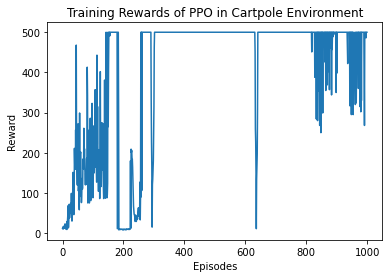

In [32]:
import matplotlib.pyplot as plt
plt.plot(r_l)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title("Training Rewards of PPO in Cartpole Environment")

In [30]:
eval_r=[]
for epoch in range(50):
    state= env.reset()
    done= False
    r=0
    while not done:
        env.render()
        a,v_old,log_p= actor_critic.step(torch.as_tensor(state,dtype=torch.float32))
        next_s, reward,done,_=env.step(a)
        state=next_s
        r+=reward
    eval_r.append(r)
        

Text(0.5, 1.0, 'Evaluation of PPO in Cartpole Environment')

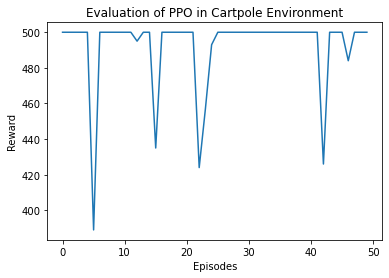

In [31]:
plt.plot(eval_r)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title("Evaluation of PPO in Cartpole Environment")